# Melanoma Detection Assignment

In [1]:
!pip install augmentor

In [2]:
# Import necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import Augmentor as aug
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import math

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [48]:
# Print python, jupyter and all the imported library versions
import sys
import jupyter_core
import matplotlib as mpt

print("python : {0}".format(sys.version))
print("jupyter : {0}".format(jupyter_core.__version__))
print("numpy : {0}".format(np.__version__))
print("pandas : {0}".format(pd.__version__))
print("matplotlib : {0}".format(mpt.__version__))
print("tensorflow : {0}".format(tf.__version__))
print("keras : {0}".format(keras.__version__))
print("augmentor : {0}".format(aug.__version__))

python : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
jupyter : 5.7.2
numpy : 1.26.4
pandas : 2.2.2
matplotlib : 3.9.2
tensorflow : 2.18.0
keras : 3.8.0
augmentor : 0.2.12


# Data Understanding

In [47]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

# Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

ModuleNotFoundError: No module named 'google.colab'

In [5]:
# Defining the path for train and test images
base_path = "/content/gdrive/MyDrive/Education/Datasets/melanoma_detection"
data_dir_train = pathlib.Path(base_path + "/train")
data_dir_test = pathlib.Path(base_path + "/test")

# Print the images loaded in both folders
print("Training images path =", data_dir_train)
print("Training images size =", len(list(data_dir_train.glob('*/*.jpg'))))
print("Testing images path =", data_dir_test)
print("Testing images size =", len(list(data_dir_test.glob('*/*.jpg'))))

Training images path = datasets/melanoma_detection/train
Training images size = 2239
Testing images path = datasets/melanoma_detection/test
Testing images size = 118


In [6]:
# Define parameters for the loader
batch_size=32
img_height=180
img_width=180

In [7]:
# Empty the output directory in case augmentor is being executed more than once
for file in list(data_dir_train.glob('*/output/*.jpg')):
    os.remove(str(file))

In [8]:
# Load the training dataset
# Color mode = rgb, seed = 123 and validation split = 20%
train_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                            labels="inferred", 
                                                            label_mode="int", 
                                                            color_mode="rgb", 
                                                            batch_size=batch_size,
                                                            image_size=(img_height, img_width),
                                                            seed=123,
                                                            validation_split=0.2,
                                                            subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Load the validation dataset
# Color mode = rgb, seed = 123 and validation split = 20%
val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                            labels="inferred", 
                                                            label_mode="int", 
                                                            color_mode="rgb", 
                                                            batch_size=batch_size,
                                                            image_size=(img_height, img_width),
                                                            seed=123,
                                                            validation_split=0.2,
                                                            subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


2025-01-15 15:43:49.090642: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-15 15:43:49.271948: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-15 15:43:49.778465: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-15 15:43:52.030995: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


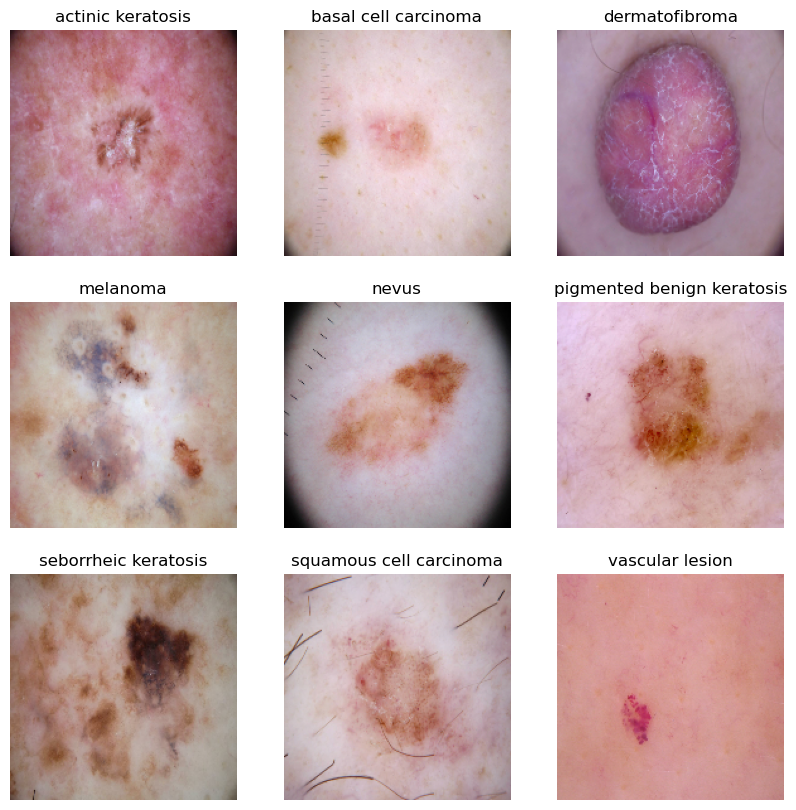

In [11]:
# Visualize one instance of all nine classes present in the dataset using the training dataset

fig = plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
plt.show()

In [12]:
# Optimize train and validation dataset using prefetch and caching
train_ds_pf = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds_pf = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
# Define function to draw the accuracy and loss results
def visualize_results(model, epochs, results):

    accuracy = results['accuracy']
    validation_accuracy = results['val_accuracy']
    
    loss = results['loss']
    validation_loss = results['val_loss']
    epochs_range = range(epochs)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy - ' + model)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss - ' + model)
    plt.show()    

In [14]:
# Fetch the input shape for the model
for image, label in train_ds_pf.take(1):
    input_shape = image[0].shape
input_shape

TensorShape([180, 180, 3])

# Model I (Simple)

In [15]:
# Steps used in the model
# 1. Rescaling
# 2. Convolution (32) + Pooling
# 3. Convolution (64) + Pooling
# 4. Convolution (128) + Pooling
# 5. Droput (0.1)
# 6. Flatten + Dense (64)
# 7. Droput (0.1)
# 8. Dense (9) + Softmax

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, input_shape=input_shape))

model1.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model1.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.1))

model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation="relu"))
model1.add(layers.Dropout(0.1))
model1.add(layers.Dense(len(class_names), activation="softmax"))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,697 (12.86 MB)

 Trainable params: 3,370,697 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Use 'adam' optimizer and 'sparse_categorical_crossentropy' loss function
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [17]:
# Fit the model for 20 epochs
epochs = 20
history = model1.fit(
    train_ds_pf,
    validation_data=val_ds_pf,
    epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.2095 - loss: 2.0559 - val_accuracy: 0.3714 - val_loss: 1.8117
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.3579 - loss: 1.8047 - val_accuracy: 0.4698 - val_loss: 1.6294
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.4473 - loss: 1.5853 - val_accuracy: 0.4899 - val_loss: 1.4957
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.4895 - loss: 1.4432 - val_accuracy: 0.4765 - val_loss: 1.5887
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.5232 - loss: 1.3742 - val_accuracy: 0.5123 - val_loss: 1.3894
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.5273 - loss: 1.3133 - val_accuracy: 0.5011 - val_loss: 1.3958
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.5386 - loss: 1.2831 - val_accuracy: 0.5235 - val_loss: 1.4421
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.5535 - loss: 1.2732 - val_accu

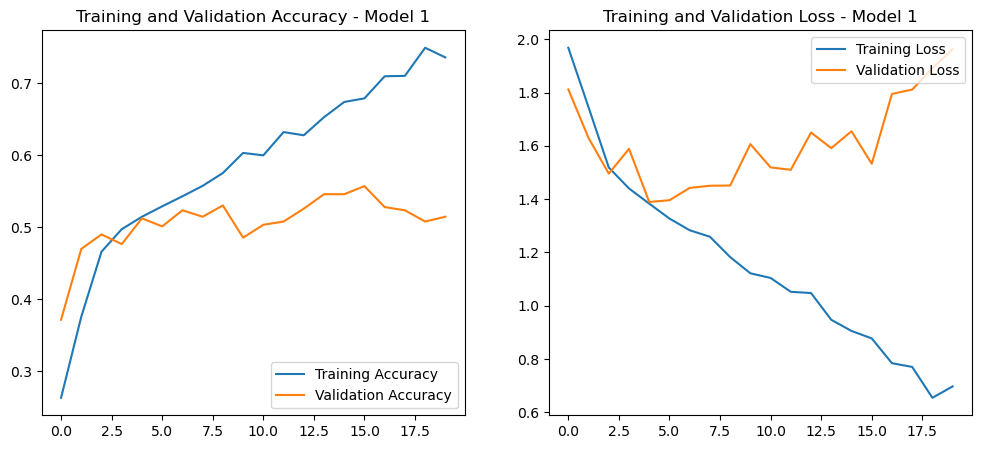

In [18]:
# Visualize the accuracy and loss for model1
visualize_results("Model 1", epochs, history.history)

### Findings

- Model seems to overfit as the training accuracy is reaching 80% but the validation accuracy remains at 50% after 20 epochs
- Training loss is constantly decreasing, as for validation loss it was decreasing till 7 epochs but then gradually started increasing

# Model II (with Augment layer)

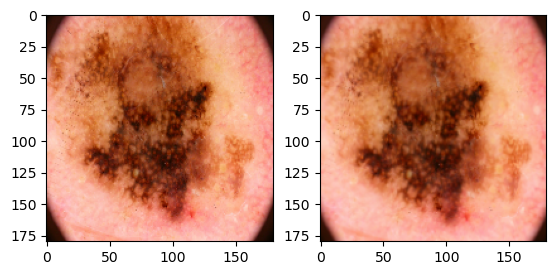

In [19]:
# Visualize augmentation strategy for one instance of training image
augment_layer = layers.Pipeline([
    layers.RandomFlip(),
    layers.RandomRotation(.1),
    layers.RandomZoom(.1)
])
    
fig = plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
    ax = plt.subplot(3, 3, 1)
    plt.imshow(image[0].numpy().astype('uint8'))
    out_img = augment_layer(image[0])
    ax = plt.subplot(3, 3, 2)
    plt.imshow(out_img.numpy().astype('uint8'))
plt.show()

In [20]:
# Steps used in the model
# 1. Rescaling
# 2. Augmentation (Flip + Rotation + Zoom)
# 3. Convolution (32) + Pooling
# 4. Convolution (64) + Pooling
# 5. Convolution (128) + Pooling
# 6. Droput (0.1)
# 7. Flatten + Dense (128)
# 8. Droput (0.1)
# 9. Dense (9) + Softmax

model2 = Sequential()

model2.add(layers.Rescaling(scale=1./255, input_shape=input_shape))
model2.add(augment_layer)

model2.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model2.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

model2.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation="relu"))
model2.add(layers.Dropout(0.1))
model2.add(layers.Dense(len(class_names), activation="softmax"))

model2.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline (Pipeline)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Use 'adam' optimizer and 'sparse_categorical_crossentropy' loss function
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [22]:
# Fit the model for 20 epochs
epochs = 20
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.2537 - loss: 1.9966 - val_accuracy: 0.3468 - val_loss: 1.7575
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.3881 - loss: 1.7144 - val_accuracy: 0.4653 - val_loss: 1.5093
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - accuracy: 0.4743 - loss: 1.5200 - val_accuracy: 0.4832 - val_loss: 1.4903
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.4890 - loss: 1.4577 - val_accuracy: 0.4877 - val_loss: 1.5687
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.4999 - loss: 1.4358 - val_accuracy: 0.5168 - val_loss: 1.4809
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.5353 - loss: 1.3433 - val_accuracy: 0.4966 - val_loss: 1.4545
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.5279 - loss: 1.3094 - val_accuracy: 0.4564 - val_loss: 1.4960
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.5358 - loss: 1.2991 - val_accu

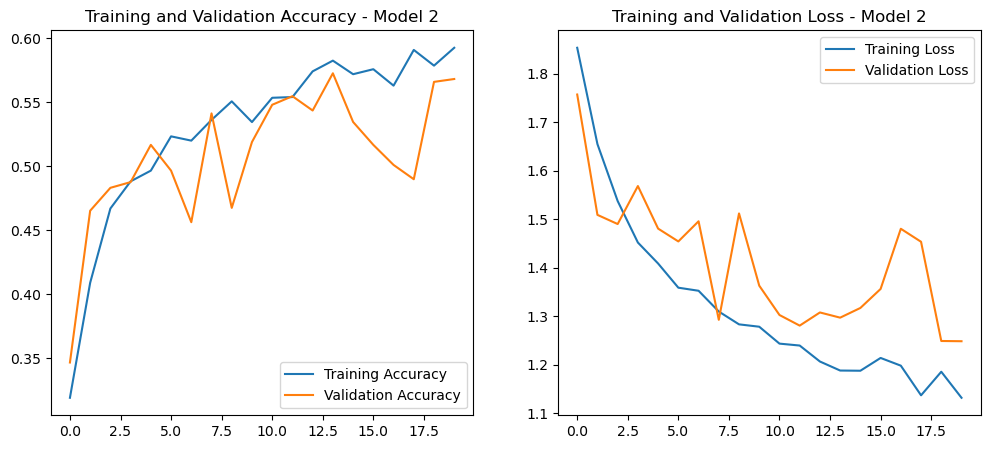

In [23]:
# Visualize the accuracy and loss for model2
visualize_results("Model 2", epochs, history.history)

### Findings

- Random augmentation solved the problem of overfitting but introduced the problem on underfitting
- Model is now underfitting as both the training and validation accuracy is between 50%-60% after 20 epochs
- Also, the training and validation loss is gradually decreasing

# Using Augmentor (increasing dataset)

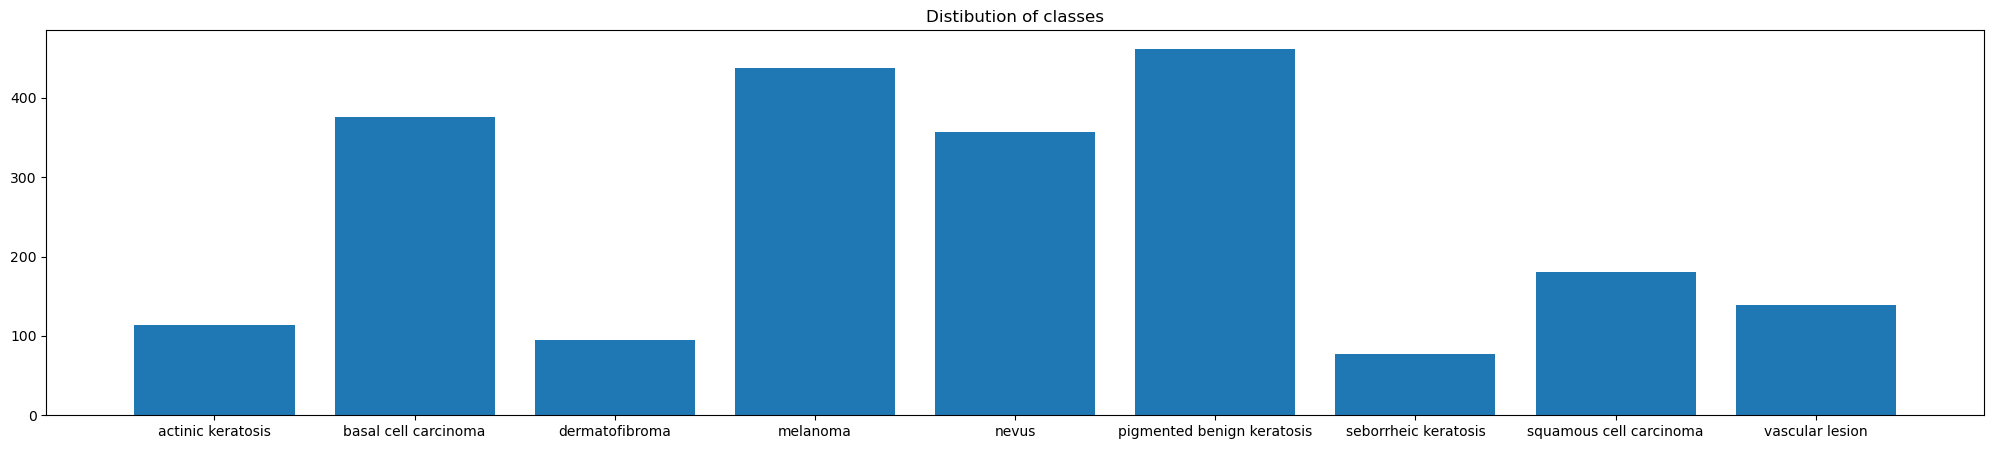

In [24]:
# Plot the distribution of different classes to see if there is a difference in data points
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))

plt.figure(figsize=(25,5))
plt.bar(class_names, count)
plt.title("Distibution of classes")
plt.show()

In [25]:
# Create an Augmentor pipeline, rotate and create sample size of 500
path_to_training_dataset=str(data_dir_train.absolute()) + "/"
for i in class_names:
    pipeline = aug.Pipeline(path_to_training_dataset + i)
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 376 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x110021A90>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x11014CCE0>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 357 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 462 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x110133F80>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x353F34B00>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x353F91C10>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/rohitaggarwal/practice/iiitb-ml-ai/course-8-deep-learning/datasets/melanoma_detection/train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3A067F500>: 100%|█|


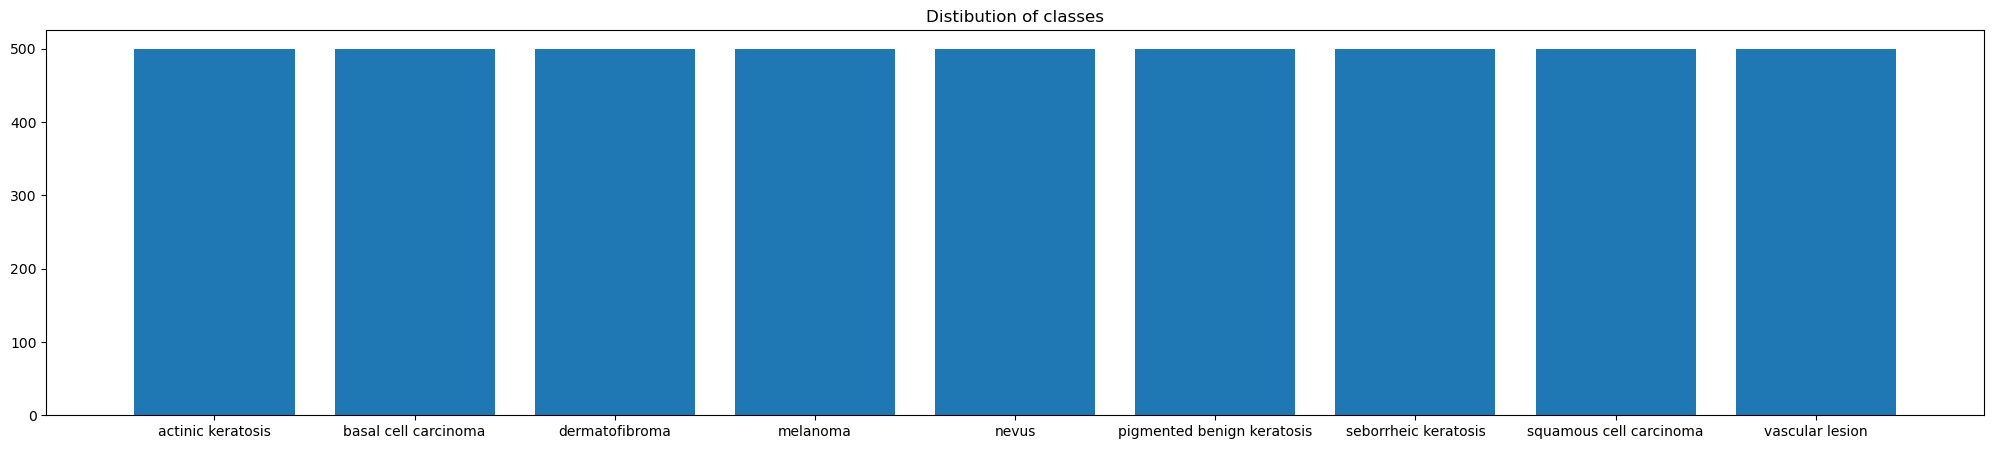

In [26]:
# Plot the distribution of different classes to see if there is a difference in data points after augmentation
count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/output/*.jpg'))))

plt.figure(figsize=(25,5))
plt.bar(class_names, count)
plt.title("Distibution of classes")
plt.show()

In [27]:
# Print the number of output images with the path list for the images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Number of images =", image_count_train)

path_list = [str(file) for file in data_dir_train.glob('*/output/*.jpg')]
path_list

Number of images = 4500


['datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0010379.jpg_4773dc8f-214b-40ba-8868-5ae3b187261f.jpg',
 'datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0000149.jpg_921bc741-d2d9-4b69-b7c9-15463a66270c.jpg',
 'datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0010131.jpg_771a6252-3358-4c73-b75b-490643263f2d.jpg',
 'datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0010631.jpg_5e28e809-1934-4bbb-99d4-9d70e1727d08.jpg',
 'datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0010355.jpg_fec300f0-f9c7-4ea4-bf7e-1bc2c5dcee19.jpg',
 'datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0010977.jpg_953d34ec-7279-474a-b778-848ef0eaade7.jpg',
 'datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0010564.jpg_b519e2eb-3473-4fb0-9d81-d9181c677004.jpg',
 'datasets/melanoma_detection/train/melanoma/output/melanoma_original_ISIC_0011139.jpg_60d

In [28]:
# Prepare a list of the lesion from the image
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(file))) for file in data_dir_train.glob('*/output/*.jpg')]
lesion_list

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [29]:
# Prepare a dataframe consisting of the augmented data
augmented_list = dict(zip(path_list, lesion_list))
augmented_df = pd.DataFrame(list(augmented_list.items()),columns = ['Path','Label'])
augmented_df

,Path,Label
0,datasets/melanoma_detection/train/melanoma/out...,melanoma
1,datasets/melanoma_detection/train/melanoma/out...,melanoma
2,datasets/melanoma_detection/train/melanoma/out...,melanoma
3,datasets/melanoma_detection/train/melanoma/out...,melanoma
4,datasets/melanoma_detection/train/melanoma/out...,melanoma
...,...,...
4495,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma
4496,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma
4497,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma
4498,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma


In [30]:
# Prepare a dataframe consisting of the original data
path_list=[]
lesion_list=[]
for name in class_names:
  for file in data_dir_train.glob(name+'/*.jpg'):
    path_list.append(str(file))
    lesion_list.append(name)

original_list = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(original_list.items()),columns=['Path','Label'])
original_df

,Path,Label
0,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
1,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
2,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
3,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
4,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
...,...,...
2234,datasets/melanoma_detection/train/vascular les...,vascular lesion
2235,datasets/melanoma_detection/train/vascular les...,vascular lesion
2236,datasets/melanoma_detection/train/vascular les...,vascular lesion
2237,datasets/melanoma_detection/train/vascular les...,vascular lesion


In [31]:
# Combine both original and augmented data
combined_df = pd.concat([original_df, augmented_df])
combined_df

,Path,Label
0,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
1,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
2,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
3,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
4,datasets/melanoma_detection/train/actinic kera...,actinic keratosis
...,...,...
4495,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma
4496,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma
4497,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma
4498,datasets/melanoma_detection/train/dermatofibro...,dermatofibroma


In [32]:
# Print the value counts for the all classes using the data fram
combined_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

# Model III (with Augmentor data)

In [33]:
# Load the training dataset
# Color mode = rgb, seed = 123 and validation split = 20%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               labels="inferred", 
                                                               label_mode="int", 
                                                               color_mode="rgb", 
                                                               seed=123,
                                                               validation_split = 0.2,
                                                               subset = "training",
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [34]:
# Load the validation dataset
# Color mode = rgb, seed = 123 and validation split = 20%
val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                            labels="inferred", 
                                                            label_mode="int", 
                                                            color_mode="rgb", 
                                                            batch_size=batch_size,
                                                            image_size=(img_height, img_width),
                                                            seed=123,
                                                            validation_split=0.2,
                                                            subset="validation")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [35]:
# Optimize train and validation dataset using prefetch and caching
train_ds_pf = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds_pf = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [40]:
# Steps used in the model
# 1. Rescaling
# 2. Convolution (32) + Pooling
# 3. Convolution (64) + Pooling
# 4. Convolution (128) + Pooling
# 5. Dropout (0.1)
# 6. Flatten + Dense (64)
# 7. Droput (0.1)
# 8. Dense (9) + Softmax

model3 = Sequential()

model3.add(layers.Rescaling(scale=1./255, input_shape=input_shape))

model3.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model3.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

model3.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Dropout(0.1))

model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation="relu"))
model3.add(layers.Dropout(0.1))
model3.add(layers.Dense(len(class_names), activation="softmax"))

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,697 (12.86 MB)

 Trainable params: 3,370,697 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Use 'adam' optimizer and 'sparse_categorical_crossentropy' loss function
model3.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [42]:
# Fit the model for 25 epochs
epochs = 25
history = model3.fit(
    train_ds_pf,
    validation_data=val_ds_pf,
    epochs=epochs
)

Epoch 1/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.1862 - loss: 2.1911 - val_accuracy: 0.3512 - val_loss: 1.6922
Epoch 2/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.3403 - loss: 1.7290 - val_accuracy: 0.4655 - val_loss: 1.4472
Epoch 3/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.4326 - loss: 1.4588 - val_accuracy: 0.4551 - val_loss: 1.4179
Epoch 4/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 207ms/step - accuracy: 0.4889 - loss: 1.3264 - val_accuracy: 0.5768 - val_loss: 1.2034
Epoch 5/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.5598 - loss: 1.1852 - val_accuracy: 0.5939 - val_loss: 1.1528
Epoch 6/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.6112 - loss: 1.0323 - val_accuracy: 0.6058 - val_loss: 1.0645
Epoch 7/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.6426 - loss: 0.9524 - val_accuracy: 0.6815 - val_loss: 0.9418
Epoch 8/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.6859 - loss: 0

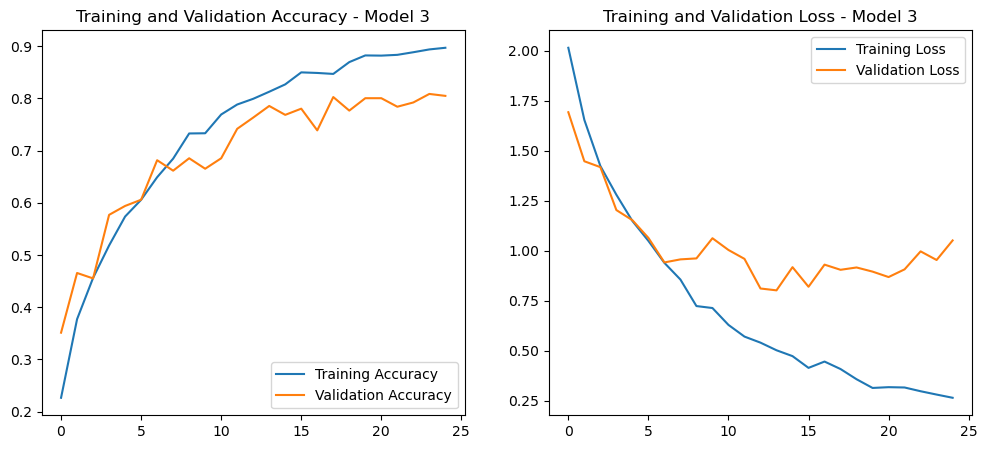

In [43]:
# Visualize the accuracy and loss for model3
visualize_results("Model 3", epochs, history.history)

### Findings

- Solving class imbalance by adding sufficient data helped make the model better
- Model overfitting problem is solved with training accuracy at 90% and validation accuracy at 80%
- Training loss has been decreasing since beginning but validation loss decreased for about 10 epochs after which it became stable